In [2]:
import os
import cv2
from tqdm import tqdm
from utils import *
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from sklearn.preprocessing import MinMaxScaler

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


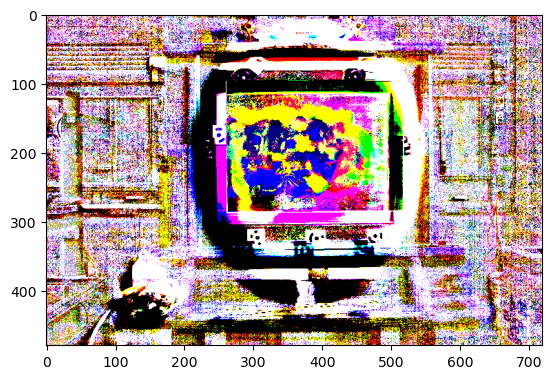

True

In [70]:
# gain calculation: (ImgA - ImgB) * gain + 0.5
impath = "./images/"
truth_raw = cv2.imread(impath + "truth.png")
truth = cv2.resize(truth_raw, (truth_raw.shape[1] // 8, truth_raw.shape[0] // 8), interpolation=cv2.INTER_LINEAR)
nerf = cv2.imread(impath + "lioncubs_nerf.png")

# convert 0-255 uint8 into 0-1 scale
truth_norm = cv2.normalize(truth, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
pred_norm = cv2.normalize(nerf, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
subtracted = truth_norm - pred_norm
gain = 5
plt.imshow(subtracted * 256 + 0.5)
plt.show()

cv2.imwrite("./temp.png", subtracted * 500 + 0.5)

In [113]:
def fourier_mse(img1, img2):
    scaler = MinMaxScaler()
    dark_image_grey = rgb2gray(img1)
    fourier_1 = np.fft.fftshift(np.fft.fft2(dark_image_grey))
    dark_image_grey = rgb2gray(img2)
    fourier_2 = np.fft.fftshift(np.fft.fft2(dark_image_grey))
    return np.sum(np.subtract(scaler.fit(fourier_1), scaler.fit(fourier_2)) ** 2)

In [19]:
def calculate_lpips(im0_addr, im1_addr, resize):
    import lpips
    loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
    # loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

    import torch
    img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
    img1 = torch.zeros(1,3,64,64)
    print(img0.shape)

    from PIL import Image
    import torchvision.transforms.functional as TF
    img0 = Image.open(im0_addr).convert('RGB')
    # width, height = img0.size
    # img0 = img0.resize((width // 8, height // 8))
    im0 = TF.to_tensor(img0)
    img1 = Image.open(im1_addr).convert('RGB')
    # width, height = img1.size
    # img1 = img1.resize((width // resize, height // resize))
    im1 = TF.to_tensor(img1)

    d = loss_fn_alex(im0, im1)

    return d[0][0][0][0]

In [20]:
impath = "./images/"
truth = cv2.imread(impath + "truth_crop.png")
print(truth.shape)
# truth = cv2.resize(truth_raw, (truth_raw.shape[1] // 8, truth_raw.shape[0] // 8), interpolation=cv2.INTER_LINEAR)
dir_list = os.listdir(impath)
for i in tqdm(dir_list):
    if i.endswith("nerf_crop.png") or i.endswith("nerfmm_crop.png"):
        print("IMAGE:", i)
        img = cv2.imread(impath + i)
        print(img.shape)
        resize = 1
        # if i.endswith("nerfmm.png"):
        #     img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
        #     resize = 2

        print("\t MSE:", mse(truth, img))
        print("\t PSNR:", psnr(truth, img))
        print("\t SSIM:", ssim(truth, img))
        print("\t LPIPS:", calculate_lpips(impath + "truth_crop.png", impath + i, resize))

(188, 257, 3)


  0%|          | 0/14 [00:00<?, ?it/s]

IMAGE: lioncubs_nerf_crop.png
(188, 257, 3)
	 MSE: 54.146342136490325
	 PSNR: 30.795112377384328
	 SSIM: 0.6664612399801851
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


 14%|█▍        | 2/14 [00:00<00:02,  5.92it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.2323, grad_fn=<SelectBackward0>)
IMAGE: lioncubs_col_nerf_crop.png
(188, 257, 3)
	 MSE: 54.06866600436018
	 PSNR: 30.80134706182097
	 SSIM: 0.665816892872306
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


 36%|███▌      | 5/14 [00:00<00:01,  7.56it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.2426, grad_fn=<SelectBackward0>)
IMAGE: lioncubs_nerfmm_crop.png
(188, 257, 3)
	 MSE: 86.93832960785937
	 PSNR: 28.73869069262671
	 SSIM: 0.4795199801167158
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


 43%|████▎     | 6/14 [00:01<00:01,  5.44it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.4303, grad_fn=<SelectBackward0>)
IMAGE: lioncubs_row_nerfmm_crop.png
(188, 257, 3)
	 MSE: 86.69464911554489
	 PSNR: 28.75088067674355
	 SSIM: 0.4626757092957548
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


 64%|██████▍   | 9/14 [00:01<00:00,  6.72it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.4421, grad_fn=<SelectBackward0>)
IMAGE: lioncubs_row_nerf_crop.png
(188, 257, 3)
	 MSE: 63.45836437894969
	 PSNR: 30.105914867743486
	 SSIM: 0.6578333980412534
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


 79%|███████▊  | 11/14 [00:01<00:00,  6.42it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.2346, grad_fn=<SelectBackward0>)
IMAGE: lioncubs_col_nerfmm_crop.png
(188, 257, 3)
	 MSE: 90.54147004442973
	 PSNR: 28.562328193832833
	 SSIM: 0.46078919052010364
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


100%|██████████| 14/14 [00:02<00:00,  6.76it/s]

Loading model from: /home/jiwon/miniconda3/envs/hologram/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 64, 64])
	 LPIPS: tensor(0.4670, grad_fn=<SelectBackward0>)
